# Module 2 Summative Lab

The below imports the necessary libraries:

In [1]:
import pandas as pd
import sqlite3 

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())

import matplotlib.pyplot as plt
%matplotlib inline

import requests
import pymongo

%load_ext autoreload
%autoreload 2

from lib import MongoHandler, WeatherGetter #add key under WeatherGetter before using this

In [2]:
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [3]:
myclient = pymongo.MongoClient("mongodb://127.0.0.1:27017/")
db = myclient["Project2"]

## ***Sqlite_master database:***

https://www.kaggle.com/laudanum/footballdelphi

The below codes provide preview of the tables inside the database: 

In [4]:
#check what the database has
print([i[0] for i in cur.execute("""SELECT * FROM sqlite_master;""").description])
cur.execute("""SELECT type, tbl_name FROM sqlite_master ORDER by type, tbl_name;""")
db = pd.DataFrame(cur.fetchall())
db.columns = [i[0] for i in cur.description]
db

['type', 'name', 'tbl_name', 'rootpage', 'sql']


,type,tbl_name
0,index,Matches
1,table,Matches
2,table,Teams
3,table,Teams_in_Matches
4,table,Unique_Teams
5,table,sqlite_sequence
6,view,FlatView
7,view,FlatView_Advanced
8,view,FlatView_Chrono_TeamOrder_Reduced


* ***Match_ID (int): unique ID per match***
* Div (str): identifies the division the match was played in (D1 = Bundesliga, D2 = Bundesliga 2, E0 = English Premier League)
* ***Season (int): Season the match took place in (usually covering the period of August till May of the following year)***
* Date (str): Date of the match
* ***HomeTeam (str): Name of the home team***
* ***AwayTeam (str): Name of the away team***
* FTHG (int) (Full Time Home Goals): Number of goals scored by the home team
* FTAG (int) (Full Time Away Goals): Number of goals scored by the away team
* FTR (str) (Full Time Result): 3-way result of the match (H = Home Win, D = Draw, A = Away Win)

In [5]:
#preview Matches table
cur.execute("""SELECT * FROM Matches LIMIT 5;""")
df_matches = pd.DataFrame(cur.fetchall())
df_matches.columns = [i[0] for i in cur.description]
df_matches.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [6]:
#get all 2011 data, only for Bundesliga division
cur.execute("""SELECT * FROM Matches WHERE Season = 2011 and (Div = "D1" or Div = "D2");""")
df_2011 = pd.DataFrame(cur.fetchall())
df_2011.columns = [i[0] for i in cur.description]
df_2011

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D
...,...,...,...,...,...,...,...,...,...
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D


In [7]:
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 9 columns):
Match_ID    612 non-null int64
Div         612 non-null object
Season      612 non-null int64
Date        612 non-null object
HomeTeam    612 non-null object
AwayTeam    612 non-null object
FTHG        612 non-null int64
FTAG        612 non-null int64
FTR         612 non-null object
dtypes: int64(4), object(5)
memory usage: 43.2+ KB


In [8]:
#check for duplicate Matches
df_2011.duplicated("Match_ID").value_counts()

False    612
dtype: int64

* ***Season (str): Football season for which the data is valid***   
* ***TeamName (str): Name of the team the data concerns***    
* KaderHome (str): Number of Players in the squad
* AvgAgeHome (str): Average age of players
* ForeignPlayersHome (str): Number of foreign players (non-German, non-English respectively) playing for the team
* OverallMarketValueHome (str): Overall market value of the team pre-season in EUR (based on data from transfermarkt.de)
* AvgMarketValueHome (str): Average market value (per player) of the team pre-season in EUR (based on data from transfermarkt.de)
* StadiumCapacity (str): Maximum stadium capacity of the team's home stadium

In [9]:
#preview Teams table
cur.execute("""SELECT * FROM Teams;""")
df_tl = pd.DataFrame(cur.fetchall())
df_tl.columns = [i[0] for i in cur.description]
df_tl.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


* ***Match_ID (int): Unique match ID***  
* ***Unique_Team_ID (int): Unique team ID (This table is used to easily retrieve each match a given team has played in)***

In [10]:
#preview Teams_in_Matches table
cur.execute("""SELECT * FROM Teams_in_Matches;""")
df_tm = pd.DataFrame(cur.fetchall())
df_tm.columns = [i[0] for i in cur.description]
df_tm.head()

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26
3,2,42
4,3,26


* ***TeamName (str): Name of a team***  
* ***Unique_Team_ID (int): Unique identifier for each team***

In [11]:
#preview FROM Unique_Teams table
cur.execute("""SELECT * FROM Unique_Teams;""")
df_ut = pd.DataFrame(cur.fetchall())
df_ut.columns = [i[0] for i in cur.description]
df_ut.head()

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


## Answers:

### The name of the team

In [12]:
q = """SELECT Unique_Team_ID as Team_ID, TeamName FROM df_ut;"""
df_names = pysqldf(q)
df_names.head()

,Team_ID,TeamName
0,1,Bayern Munich
1,2,Dortmund
2,3,Leverkusen
3,4,RB Leipzig
4,5,Schalke 04


In [13]:
#convert the table to a dict which be loaded to the db
name_list = df_names.to_dict("records")
name_list

[{'Team_ID': 1, 'TeamName': 'Bayern Munich'},
 {'Team_ID': 2, 'TeamName': 'Dortmund'},
 {'Team_ID': 3, 'TeamName': 'Leverkusen'},
 {'Team_ID': 4, 'TeamName': 'RB Leipzig'},
 {'Team_ID': 5, 'TeamName': 'Schalke 04'},
 {'Team_ID': 6, 'TeamName': "M'gladbach"},
 {'Team_ID': 7, 'TeamName': 'Wolfsburg'},
 {'Team_ID': 8, 'TeamName': 'FC Koln'},
 {'Team_ID': 9, 'TeamName': 'Hoffenheim'},
 {'Team_ID': 10, 'TeamName': 'Hertha'},
 {'Team_ID': 11, 'TeamName': 'Mainz'},
 {'Team_ID': 12, 'TeamName': 'Hamburg'},
 {'Team_ID': 13, 'TeamName': 'Werder Bremen'},
 {'Team_ID': 14, 'TeamName': 'Ein Frankfurt'},
 {'Team_ID': 15, 'TeamName': 'Augsburg'},
 {'Team_ID': 16, 'TeamName': 'Freiburg'},
 {'Team_ID': 17, 'TeamName': 'Stuttgart'},
 {'Team_ID': 18, 'TeamName': 'Hannover'},
 {'Team_ID': 19, 'TeamName': 'Ingolstadt'},
 {'Team_ID': 20, 'TeamName': 'Darmstadt'},
 {'Team_ID': 21, 'TeamName': 'Paderborn'},
 {'Team_ID': 22, 'TeamName': 'Nurnberg'},
 {'Team_ID': 23, 'TeamName': 'Braunschweig'},
 {'Team_ID': 24

In [14]:
#load list to MongoDB
#__init__(self, row_dict = None, collection = None)
#list of collections
# team = db["Team_Names"]
# goals = db["Team_Goals"]
# wins = db["Team_Wins"]
# winslosses = db["Wins_and_Losses"]
# rain = db["Rain_Stats"]

MongoHandler(name_list, "team")

### The total number of goals scored by the team during the 2011 season

In [15]:
#get a table of Home Teams' goals
q1 = """SELECT HomeTeam as Team, sum(FTHG) as HG FROM df_2011 GROUP by Team;"""
df_home = pysqldf(q1)
print(df_home.head())
print(df_home.shape)

#get a table of Away Teams' goals
q2 = """SELECT AwayTeam as Team, sum(FTAG) as AG FROM df_2011 GROUP by Team;"""
df_away = pysqldf(q2)
print(df_away.head())
print(df_away.shape)

            Team  HG
0         Aachen  15
1       Augsburg  20
2  Bayern Munich  49
3         Bochum  23
4   Braunschweig  21
(36, 2)
            Team  AG
0         Aachen  15
1       Augsburg  16
2  Bayern Munich  28
3         Bochum  18
4   Braunschweig  16
(36, 2)


In [16]:
#merge the 2 above to get the total goals per team
q3 = """SELECT Team, (h.HG + a.AG) as Total_2011_Goals 
        FROM df_home as h
        JOIN df_away as a
        USING (Team)
        GROUP by Team;"""

df_goals = pysqldf(q3)
df_goals.head()

,Team,Total_2011_Goals
0,Aachen,30
1,Augsburg,36
2,Bayern Munich,77
3,Bochum,41
4,Braunschweig,37


In [17]:
#convert the table to a dict which be loaded to the db
goal_list = df_goals.to_dict("records")
goal_list

[{'Team': 'Aachen', 'Total_2011_Goals': 30},
 {'Team': 'Augsburg', 'Total_2011_Goals': 36},
 {'Team': 'Bayern Munich', 'Total_2011_Goals': 77},
 {'Team': 'Bochum', 'Total_2011_Goals': 41},
 {'Team': 'Braunschweig', 'Total_2011_Goals': 37},
 {'Team': 'Cottbus', 'Total_2011_Goals': 30},
 {'Team': 'Dortmund', 'Total_2011_Goals': 80},
 {'Team': 'Dresden', 'Total_2011_Goals': 50},
 {'Team': 'Duisburg', 'Total_2011_Goals': 42},
 {'Team': 'Ein Frankfurt', 'Total_2011_Goals': 76},
 {'Team': 'Erzgebirge Aue', 'Total_2011_Goals': 31},
 {'Team': 'FC Koln', 'Total_2011_Goals': 39},
 {'Team': 'Fortuna Dusseldorf', 'Total_2011_Goals': 64},
 {'Team': 'Frankfurt FSV', 'Total_2011_Goals': 43},
 {'Team': 'Freiburg', 'Total_2011_Goals': 45},
 {'Team': 'Greuther Furth', 'Total_2011_Goals': 73},
 {'Team': 'Hamburg', 'Total_2011_Goals': 35},
 {'Team': 'Hannover', 'Total_2011_Goals': 41},
 {'Team': 'Hansa Rostock', 'Total_2011_Goals': 34},
 {'Team': 'Hertha', 'Total_2011_Goals': 38},
 {'Team': 'Hoffenheim', 

In [18]:
#load list to MongoDB
#__init__(self, row_dict = None, collection = None)
#list of collections
# team = db["Team_Names"]
# goals = db["Team_Goals"]
# wins = db["Team_Wins"]
# winslosses = db["Wins_and_Losses"]
# rain = db["Rain_Stats"]

MongoHandler(goal_list, "goals")

### The total number of wins the team earned during the 2011 season

In [19]:
#get a table of Home Teams' wins
q1 = """SELECT HomeTeam as Team, count(FTR) as Wins FROM df_2011 WHERE FTR = 'H' GROUP by Team;"""
df_home2 = pysqldf(q1)
print(df_home2.head())
print(df_home2.shape)

#get a table of Away Teams' wins
q2 = """SELECT AwayTeam as Team, count(FTR) as Wins FROM df_2011 WHERE FTR = 'A' GROUP by Team;"""
df_away2 = pysqldf(q2)
print(df_away2.head())
print(df_away2.shape)

            Team  Wins
0         Aachen     4
1       Augsburg     6
2  Bayern Munich    14
3         Bochum     7
4   Braunschweig     6
(36, 2)
            Team  Wins
0         Aachen     2
1       Augsburg     2
2  Bayern Munich     9
3         Bochum     3
4   Braunschweig     4
(36, 2)


In [20]:
#merge the 2 above to get the total wins per team
q3 = """SELECT Team, (h.Wins + a.Wins) as Total_2011_Wins
        FROM df_home2 as h
        JOIN df_away2 as a
        USING (Team)
        GROUP by Team;"""
df_wins = pysqldf(q3)
df_wins.head()

,Team,Total_2011_Wins
0,Aachen,6
1,Augsburg,8
2,Bayern Munich,23
3,Bochum,10
4,Braunschweig,10


In [21]:
#convert the table to a dict which be loaded to the db
win_list = df_wins.to_dict("records")
win_list

[{'Team': 'Aachen', 'Total_2011_Wins': 6},
 {'Team': 'Augsburg', 'Total_2011_Wins': 8},
 {'Team': 'Bayern Munich', 'Total_2011_Wins': 23},
 {'Team': 'Bochum', 'Total_2011_Wins': 10},
 {'Team': 'Braunschweig', 'Total_2011_Wins': 10},
 {'Team': 'Cottbus', 'Total_2011_Wins': 8},
 {'Team': 'Dortmund', 'Total_2011_Wins': 25},
 {'Team': 'Dresden', 'Total_2011_Wins': 12},
 {'Team': 'Duisburg', 'Total_2011_Wins': 10},
 {'Team': 'Ein Frankfurt', 'Total_2011_Wins': 20},
 {'Team': 'Erzgebirge Aue', 'Total_2011_Wins': 8},
 {'Team': 'FC Koln', 'Total_2011_Wins': 8},
 {'Team': 'Fortuna Dusseldorf', 'Total_2011_Wins': 16},
 {'Team': 'Frankfurt FSV', 'Total_2011_Wins': 7},
 {'Team': 'Freiburg', 'Total_2011_Wins': 10},
 {'Team': 'Greuther Furth', 'Total_2011_Wins': 20},
 {'Team': 'Hamburg', 'Total_2011_Wins': 8},
 {'Team': 'Hannover', 'Total_2011_Wins': 12},
 {'Team': 'Hansa Rostock', 'Total_2011_Wins': 5},
 {'Team': 'Hertha', 'Total_2011_Wins': 7},
 {'Team': 'Hoffenheim', 'Total_2011_Wins': 10},
 {'Te

In [22]:
#load list to MongoDB
#__init__(self, row_dict = None, collection = None)
#list of collections
# team = db["Team_Names"]
# goals = db["Team_Goals"]
# wins = db["Team_Wins"]
# winslosses = db["Wins_and_Losses"]
# rain = db["Rain_Stats"]

MongoHandler(win_list, "wins")

### A bar graph visualization of the team's wins and losses for the 2011 season (store the visualization directly)

In [23]:
#FTR as binary columns for easy calculation
df_2011["Home_Wins"] = df_2011["FTR"].map(lambda x: 1 if x == "H" else 0)
df_2011["Away_Wins"] = df_2011["FTR"].map(lambda x: 1 if x == "A" else 0)
df_2011["Home_Losses"] = df_2011["FTR"].map(lambda x: 1 if x == "A" else 0)
df_2011["Away_Losses"] = df_2011["FTR"].map(lambda x: 1 if x == "H" else 0)
df_2011

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Home_Wins,Away_Wins,Home_Losses,Away_Losses
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,0,1,1,0
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A,0,1,1,0
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A,0,1,1,0
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H,1,0,0,1
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,1699,D2,2011,2011-07-24,Paderborn,Fortuna Dusseldorf,1,1,D,0,0,0,0
608,1700,D2,2011,2011-12-10,Bochum,Fortuna Dusseldorf,1,1,D,0,0,0,0
609,1701,D2,2011,2011-08-15,Ein Frankfurt,Fortuna Dusseldorf,1,1,D,0,0,0,0
610,1702,D2,2011,2011-08-27,Aachen,Fortuna Dusseldorf,0,0,D,0,0,0,0


In [24]:
#get a table of Home Teams' stats
q1 = """SELECT HomeTeam as Team, sum(Home_Wins) as Home_Wins,  sum(Home_Losses) as Home_Losses FROM df_2011 GROUP by Team;"""
df_homestats = pysqldf(q1)
print(df_homestats.head())
print(df_homestats.shape)

#get a table of Away Teams' stats
q2 = """SELECT AwayTeam as Team, sum(Away_Wins) as Away_Wins,  sum(Away_Losses) as Away_Losses FROM df_2011 GROUP by Team;"""
df_awaystats = pysqldf(q2)
print(df_awaystats.head())
print(df_awaystats.shape)

            Team  Home_Wins  Home_Losses
0         Aachen          4            7
1       Augsburg          6            4
2  Bayern Munich         14            2
3         Bochum          7            7
4   Braunschweig          6            3
(36, 3)
            Team  Away_Wins  Away_Losses
0         Aachen          2            8
1       Augsburg          2            8
2  Bayern Munich          9            5
3         Bochum          3           10
4   Braunschweig          4            6
(36, 3)


In [25]:
#merge the 2 stats table
df_stats = pd.merge(df_homestats, df_awaystats, on = "Team")
df_stats

,Team,Home_Wins,Home_Losses,Away_Wins,Away_Losses
0,Aachen,4,7,2,8
1,Augsburg,6,4,2,8
2,Bayern Munich,14,2,9,5
3,Bochum,7,7,3,10
4,Braunschweig,6,3,4,6
5,Cottbus,4,5,4,10
6,Dortmund,14,1,11,2
7,Dresden,8,4,4,9
8,Duisburg,8,7,2,8
9,Ein Frankfurt,11,1,9,5


In [26]:
#add columns for total wins and losses
df_stats["Total_Wins"] = df_stats["Home_Wins"] + df_stats["Away_Wins"]
df_stats["Total_Losses"] = df_stats["Home_Losses"] + df_stats["Away_Losses"]
df_stats.sort_values("Total_Wins", inplace= True)
df_stats.head()

,Team,Home_Wins,Home_Losses,Away_Wins,Away_Losses,Total_Wins,Total_Losses
22,Kaiserslautern,2,10,2,9,4,19
18,Hansa Rostock,3,7,2,10,5,17
0,Aachen,4,7,2,8,6,15
19,Hertha,4,10,3,7,7,17
13,Frankfurt FSV,3,4,4,9,7,13


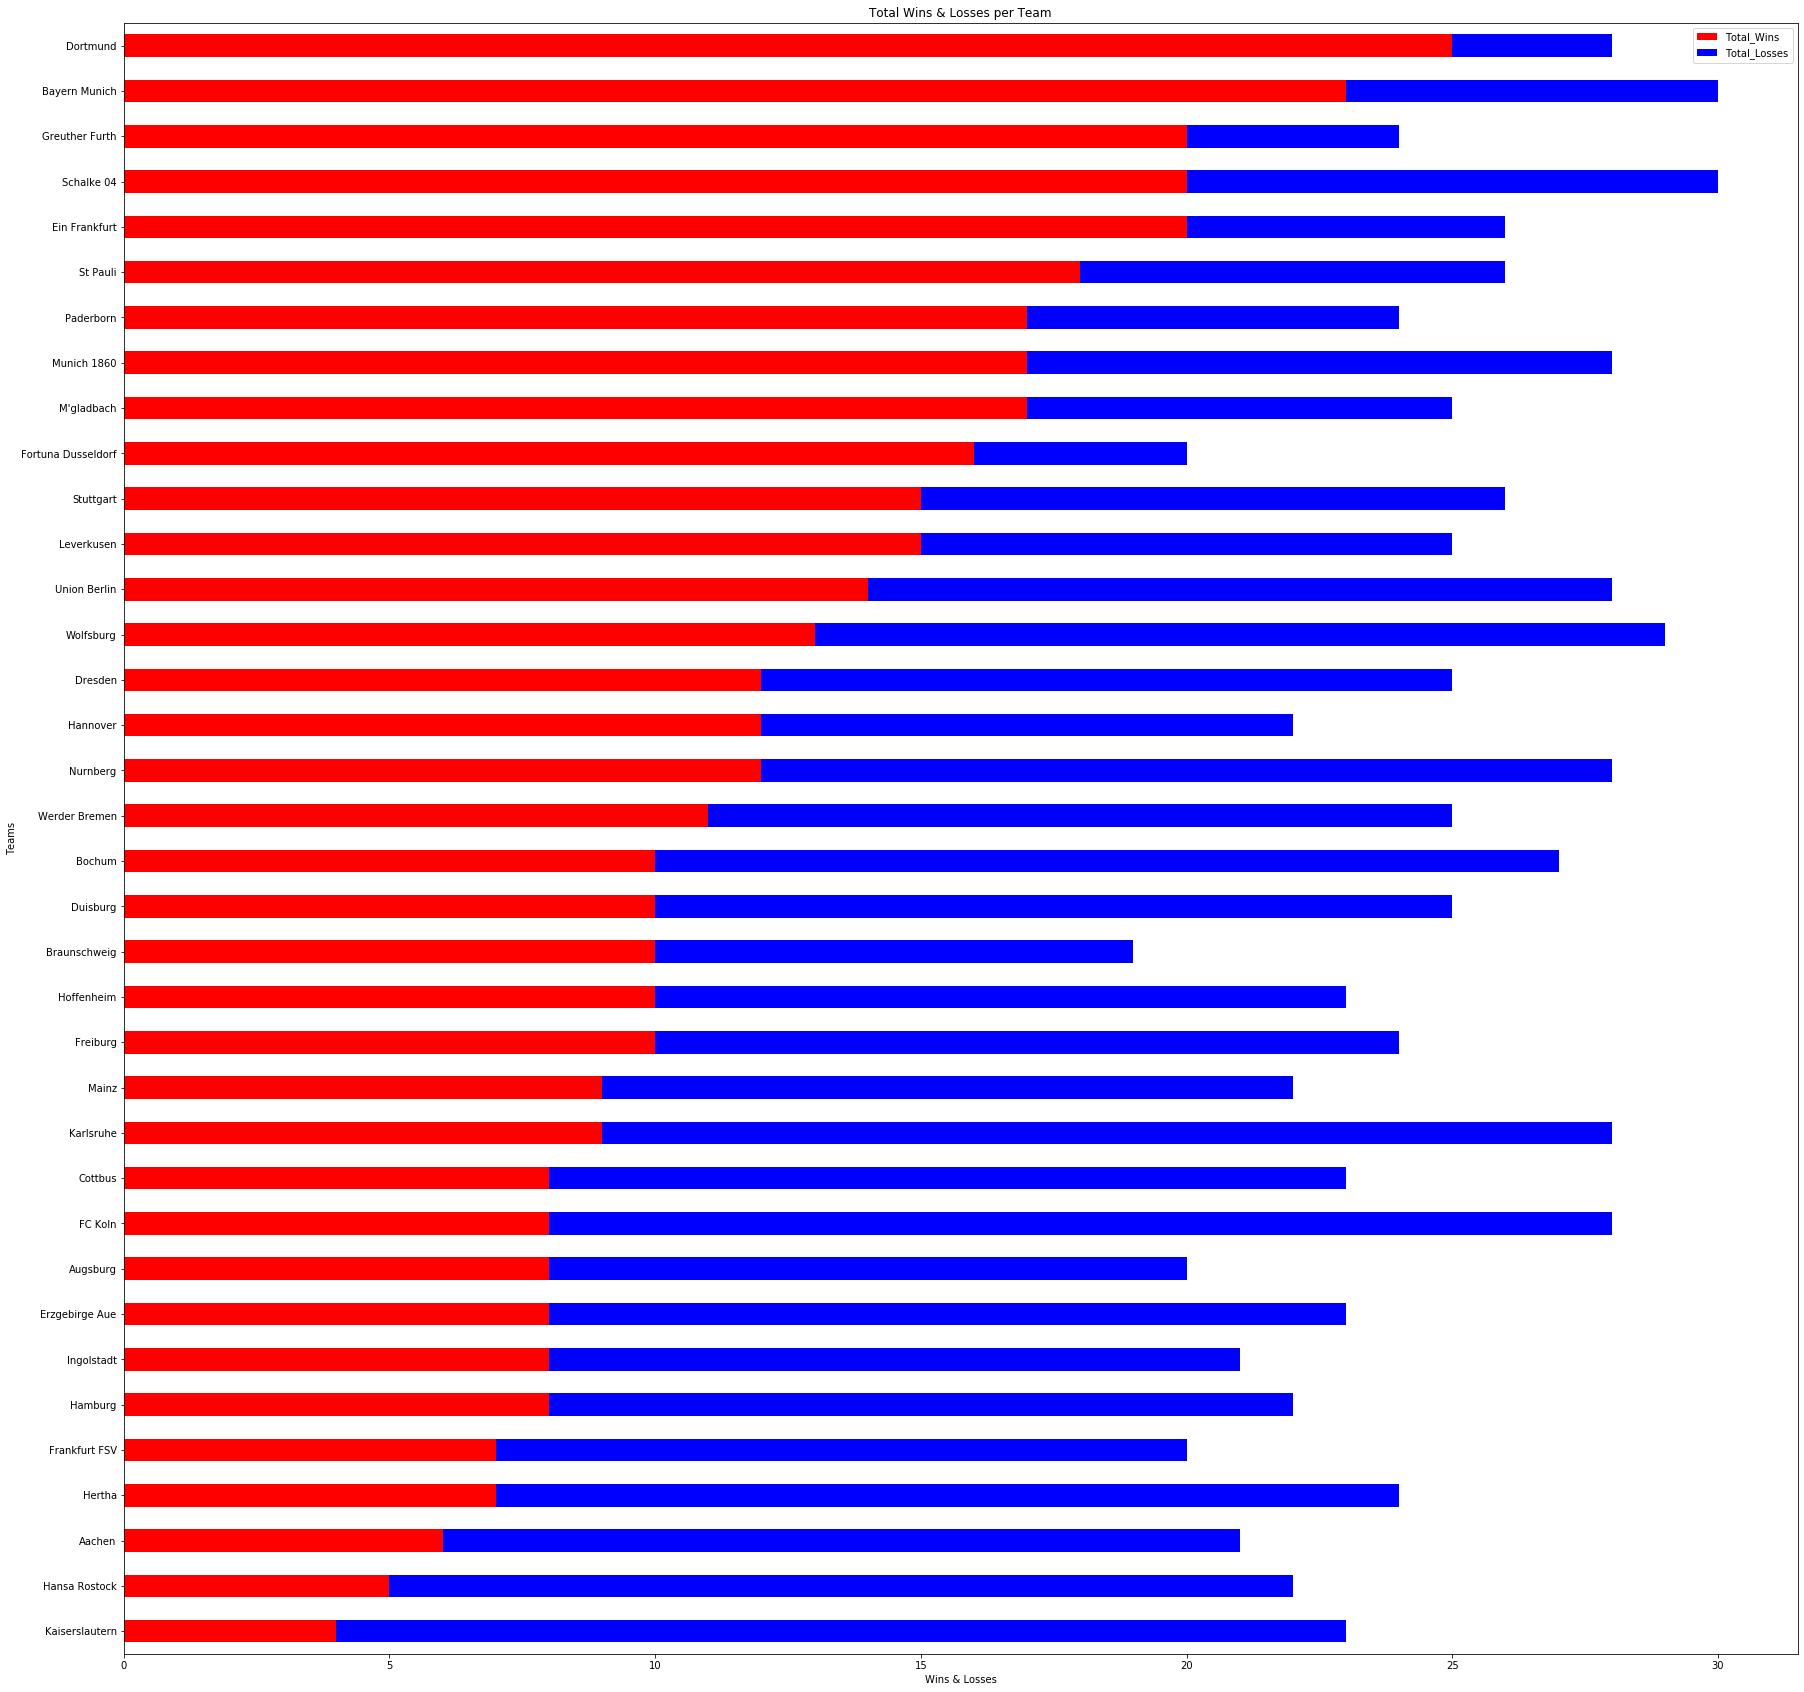

In [27]:
df_stats[["Team", "Total_Wins", "Total_Losses"]].plot(x = "Team", kind = "barh", stacked = "True", figsize = [30,30], color = ["red", "blue"])
plt.xlabel("Wins & Losses")
plt.ylabel("Teams")
plt.title("Total Wins & Losses per Team")
plt.show()

In [28]:
#convert the table to a dict which be loaded to the db
stats_list = df_stats.to_dict("records")
stats_list

[{'Team': 'Kaiserslautern',
  'Home_Wins': 2,
  'Home_Losses': 10,
  'Away_Wins': 2,
  'Away_Losses': 9,
  'Total_Wins': 4,
  'Total_Losses': 19},
 {'Team': 'Hansa Rostock',
  'Home_Wins': 3,
  'Home_Losses': 7,
  'Away_Wins': 2,
  'Away_Losses': 10,
  'Total_Wins': 5,
  'Total_Losses': 17},
 {'Team': 'Aachen',
  'Home_Wins': 4,
  'Home_Losses': 7,
  'Away_Wins': 2,
  'Away_Losses': 8,
  'Total_Wins': 6,
  'Total_Losses': 15},
 {'Team': 'Hertha',
  'Home_Wins': 4,
  'Home_Losses': 10,
  'Away_Wins': 3,
  'Away_Losses': 7,
  'Total_Wins': 7,
  'Total_Losses': 17},
 {'Team': 'Frankfurt FSV',
  'Home_Wins': 3,
  'Home_Losses': 4,
  'Away_Wins': 4,
  'Away_Losses': 9,
  'Total_Wins': 7,
  'Total_Losses': 13},
 {'Team': 'Hamburg',
  'Home_Wins': 3,
  'Home_Losses': 7,
  'Away_Wins': 5,
  'Away_Losses': 7,
  'Total_Wins': 8,
  'Total_Losses': 14},
 {'Team': 'Ingolstadt',
  'Home_Wins': 6,
  'Home_Losses': 3,
  'Away_Wins': 2,
  'Away_Losses': 10,
  'Total_Wins': 8,
  'Total_Losses': 13},
 {'

In [29]:
#load list to MongoDB
#__init__(self, row_dict = None, collection = None)
#list of collections
# team = db["Team_Names"]
# goals = db["Team_Goals"]
# wins = db["Team_Wins"]
# winslosses = db["Wins_and_Losses"]
# rain = db["Rain_Stats"]

MongoHandler(stats_list, "winslosses")

### The team's win percentage on days where it was raining during games in the 2011 season.

In [30]:
#prepare a table to get a weather

df_days = pd.DataFrame(df_2011["Date"].drop_duplicates(keep="first"))
df_days["Object"] = pd.Series([])
df_days["Weather_Summary"] = pd.Series([])

df_days.head()

,Date,Object,Weather_Summary
0,2012-03-31,NaN,NaN
1,2011-12-11,NaN,NaN
2,2011-08-13,NaN,NaN
3,2011-11-27,NaN,NaN
4,2012-02-18,NaN,NaN


In [31]:
#test darksky api for one date
#check format for weather https://darksky.net/dev/docs  ---> time machine request
#https://api.darksky.net/forecast/[key]/[latitude],[longitude],[time]
#add key before running

r = requests.get("https://api.darksky.net/forecast/[____KEY HERE____]/52.52,13.405,2019-10-21T12:00:00?exclude=currently,hourly,flags")
response = r.json()
response

{'latitude': 52.52,
 'longitude': 13.405,
 'timezone': 'Europe/Berlin',
 'daily': {'data': [{'time': 1571608800,
    'summary': 'Overcast throughout the day.',
    'icon': 'cloudy',
    'sunriseTime': 1571636580,
    'sunsetTime': 1571673660,
    'moonPhase': 0.76,
    'precipIntensity': 0.0001,
    'precipIntensityMax': 0.0003,
    'precipIntensityMaxTime': 1571617800,
    'precipProbability': 0.15,
    'precipType': 'rain',
    'temperatureHigh': 63.52,
    'temperatureHighTime': 1571668980,
    'temperatureLow': 49.04,
    'temperatureLowTime': 1571713200,
    'apparentTemperatureHigh': 63.02,
    'apparentTemperatureHighTime': 1571668980,
    'apparentTemperatureLow': 48.91,
    'apparentTemperatureLowTime': 1571713200,
    'dewPoint': 54.31,
    'humidity': 0.87,
    'pressure': 1016.9,
    'windSpeed': 4.44,
    'windGust': 19.79,
    'windGustTime': 1571608800,
    'windBearing': 167,
    'cloudCover': 0.93,
    'uvIndex': 2,
    'uvIndexTime': 1571655240,
    'visibility': 6.21

In [32]:
response.keys()

dict_keys(['latitude', 'longitude', 'timezone', 'daily', 'offset'])

In [33]:
response["daily"].keys()

dict_keys(['data'])

In [34]:
response["daily"]["data"]

[{'time': 1571608800,
  'summary': 'Overcast throughout the day.',
  'icon': 'cloudy',
  'sunriseTime': 1571636580,
  'sunsetTime': 1571673660,
  'moonPhase': 0.76,
  'precipIntensity': 0.0001,
  'precipIntensityMax': 0.0003,
  'precipIntensityMaxTime': 1571617800,
  'precipProbability': 0.15,
  'precipType': 'rain',
  'temperatureHigh': 63.52,
  'temperatureHighTime': 1571668980,
  'temperatureLow': 49.04,
  'temperatureLowTime': 1571713200,
  'apparentTemperatureHigh': 63.02,
  'apparentTemperatureHighTime': 1571668980,
  'apparentTemperatureLow': 48.91,
  'apparentTemperatureLowTime': 1571713200,
  'dewPoint': 54.31,
  'humidity': 0.87,
  'pressure': 1016.9,
  'windSpeed': 4.44,
  'windGust': 19.79,
  'windGustTime': 1571608800,
  'windBearing': 167,
  'cloudCover': 0.93,
  'uvIndex': 2,
  'uvIndexTime': 1571655240,
  'visibility': 6.216,
  'ozone': 272,
  'temperatureMin': 51.81,
  'temperatureMinTime': 1571637060,
  'temperatureMax': 63.52,
  'temperatureMaxTime': 1571668980,
  'a

In [35]:
response["daily"]["data"][0]["icon"]

'cloudy'

In [36]:
#while testing for the dates required, found out that 'icon' is not always available, so instead get 'summary'
response["daily"]["data"][0]["summary"]

'Overcast throughout the day.'

In [37]:
#READ!!!!! before running check whether lib.py has been updated with the key

# for i in range(len(df_days["Date"])):
#     df_days["Object"].iloc[i] = WeatherGetter(df_days["Date"].iloc[i])
#     df_days["Weather_Summary"].iloc[i] = df_days["Object"].iloc[i].weather

In [38]:
#df_days

In [39]:
#saved the weather data as csv file so no need to rerun GetWeather()
#df_days[["Date", "Object", "Weather_Summary"]].to_csv('days.csv')

In [40]:
df_days = pd.read_csv('days.csv', index_col = "Unnamed: 0")

In [41]:
df_days.head()

,Date,Object,Weather_Summary
0,2012-03-31,<lib.WeatherGetter object at 0x11ea4ca20>,rain
1,2011-12-11,<lib.WeatherGetter object at 0x11ea4c2e8>,partly-cloudy-day
2,2011-08-13,<lib.WeatherGetter object at 0x11ea4c828>,partly-cloudy-day
3,2011-11-27,<lib.WeatherGetter object at 0x11ea4ce48>,partly-cloudy-day
4,2012-02-18,<lib.WeatherGetter object at 0x11ea4c8d0>,partly-cloudy-day


In [42]:
#so only 'rain' is a rainy day
df_days["Weather_Summary"].unique()

array(['rain', 'partly-cloudy-day', 'Clear throughout the day.',
       'Foggy in the morning.', 'Partly cloudy throughout the day.',
       'Mostly cloudy throughout the day.', 'clear-day',
       'Foggy overnight.'], dtype=object)

In [43]:
#add the weather info to the df_2011 table (2011 season, only for Bundesliga division)
df_final = pd.merge(df_2011, df_days, on = "Date")
df_final.drop(columns = ["Object"], inplace = True)
df_final

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Home_Wins,Away_Wins,Home_Losses,Away_Losses,Weather_Summary
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,0,1,1,0,rain
1,1189,D1,2011,2012-03-31,Augsburg,FC Koln,2,1,H,1,0,0,1,rain
2,1206,D1,2011,2012-03-31,Leverkusen,Freiburg,0,2,A,0,1,1,0,rain
3,1215,D1,2011,2012-03-31,Kaiserslautern,Hamburg,0,1,A,0,1,1,0,rain
4,1396,D2,2011,2012-03-31,Munich 1860,Hansa Rostock,0,1,A,0,1,1,0,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,1689,D2,2011,2011-12-05,Duisburg,Fortuna Dusseldorf,0,2,A,0,1,1,0,partly-cloudy-day
608,1690,D2,2011,2012-04-16,Dresden,Fortuna Dusseldorf,2,1,H,1,0,0,1,Clear throughout the day.
609,1694,D2,2011,2011-10-03,Braunschweig,Fortuna Dusseldorf,1,1,D,0,0,0,0,Clear throughout the day.
610,1696,D2,2011,2012-03-19,Cottbus,Fortuna Dusseldorf,1,1,D,0,0,0,0,partly-cloudy-day


In [44]:
#add binary columns for Rain and No_Rain (not raining)
df_final["Rain"] = df_final["Weather_Summary"].map(lambda x: 1 if x == "rain" else 0)
df_final["No_Rain"] = df_final["Weather_Summary"].map(lambda x: 1 if x != "rain" else 0)
df_final.drop(columns = "Weather_Summary", inplace = True)

In [45]:
df_final

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,Home_Wins,Away_Wins,Home_Losses,Away_Losses,Rain,No_Rain
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A,0,1,1,0,1,0
1,1189,D1,2011,2012-03-31,Augsburg,FC Koln,2,1,H,1,0,0,1,1,0
2,1206,D1,2011,2012-03-31,Leverkusen,Freiburg,0,2,A,0,1,1,0,1,0
3,1215,D1,2011,2012-03-31,Kaiserslautern,Hamburg,0,1,A,0,1,1,0,1,0
4,1396,D2,2011,2012-03-31,Munich 1860,Hansa Rostock,0,1,A,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,1689,D2,2011,2011-12-05,Duisburg,Fortuna Dusseldorf,0,2,A,0,1,1,0,0,1
608,1690,D2,2011,2012-04-16,Dresden,Fortuna Dusseldorf,2,1,H,1,0,0,1,0,1
609,1694,D2,2011,2011-10-03,Braunschweig,Fortuna Dusseldorf,1,1,D,0,0,0,0,0,1
610,1696,D2,2011,2012-03-19,Cottbus,Fortuna Dusseldorf,1,1,D,0,0,0,0,0,1


In [46]:
#remove unnecessary columns
q = """SELECT Date, HomeTeam, AwayTeam, Rain, No_Rain, Home_Wins, Home_Losses, Away_Wins, Away_Losses FROM df_final;"""
df_rain = pysqldf(q)
df_rain

,Date,HomeTeam,AwayTeam,Rain,No_Rain,Home_Wins,Home_Losses,Away_Wins,Away_Losses
0,2012-03-31,Nurnberg,Bayern Munich,1,0,0,1,1,0
1,2012-03-31,Augsburg,FC Koln,1,0,1,0,0,1
2,2012-03-31,Leverkusen,Freiburg,1,0,0,1,1,0
3,2012-03-31,Kaiserslautern,Hamburg,1,0,0,1,1,0
4,2012-03-31,Munich 1860,Hansa Rostock,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
607,2011-12-05,Duisburg,Fortuna Dusseldorf,0,1,0,1,1,0
608,2012-04-16,Dresden,Fortuna Dusseldorf,0,1,1,0,0,1
609,2011-10-03,Braunschweig,Fortuna Dusseldorf,0,1,0,0,0,0
610,2012-03-19,Cottbus,Fortuna Dusseldorf,0,1,0,0,0,0


In [47]:
#group binary columns by HomeTeam
q1 = """SELECT HomeTeam as Team, sum(Rain) as Home_Rain, sum(No_Rain) as Home_No_Rain, sum(Home_Wins) as Home_Wins, sum(Home_Losses) as Home_Losses FROM df_rain GROUP BY HomeTeam;"""
df_rain_home = pysqldf(q1)
print(df_rain_home.head())
print(df_rain_home.shape)

#group binary columns by Away Team
q2 = """SELECT AwayTeam as Team, sum(Rain) as Away_Rain, sum(No_Rain) as Away_No_Rain, sum(Away_Wins) as Away_Wins, sum(Away_Losses) as Away_Losses FROM df_rain GROUP BY AwayTeam;"""
df_rain_away = pysqldf(q2)
print(df_rain_away.head())
print(df_rain_away.shape)

#merge the above tables
df_rainstats = pd.merge(df_rain_home, df_rain_away, on = "Team")
print(df_rainstats.head())

            Team  Home_Rain  Home_No_Rain  Home_Wins  Home_Losses
0         Aachen          5            12          4            7
1       Augsburg          7            10          6            4
2  Bayern Munich          4            13         14            2
3         Bochum          5            12          7            7
4   Braunschweig          4            13          6            3
(36, 5)
            Team  Away_Rain  Away_No_Rain  Away_Wins  Away_Losses
0         Aachen          8             9          2            8
1       Augsburg          4            13          2            8
2  Bayern Munich          7            10          9            5
3         Bochum          6            11          3           10
4   Braunschweig          5            12          4            6
(36, 5)
            Team  Home_Rain  Home_No_Rain  Home_Wins  Home_Losses  Away_Rain  \
0         Aachen          5            12          4            7          8   
1       Augsburg          7     

In [48]:
#add total columns and Win:Rain percentage
df_rainstats["Total_Wins"] = df_rainstats["Home_Wins"] + df_rainstats["Away_Wins"]
df_rainstats["Total_Losses"] = df_rainstats["Home_Losses"] + df_rainstats["Away_Losses"]
df_rainstats["Total_Rainy_Matches"]  = df_rainstats["Home_Rain"] + df_rainstats["Away_Rain"]
df_rainstats["Total_Not_Rainy_Matches"]  = df_rainstats["Home_No_Rain"] + df_rainstats["Away_No_Rain"]
df_rainstats["Wins:Rain"] = df_rainstats["Total_Wins"] / df_rainstats["Total_Rainy_Matches"]

In [49]:
df_rainstats[["Team", "Total_Rainy_Matches", "Total_Not_Rainy_Matches", "Total_Wins", "Total_Losses", "Wins:Rain"]].head()
#Aachen: so for 13 rainy days they played, they won 6 times or 46%

,Team,Total_Rainy_Matches,Total_Not_Rainy_Matches,Total_Wins,Total_Losses,Wins:Rain
0,Aachen,13,21,6,15,0.461538
1,Augsburg,11,23,8,12,0.727273
2,Bayern Munich,11,23,23,7,2.090909
3,Bochum,11,23,10,17,0.909091
4,Braunschweig,9,25,10,9,1.111111


In [50]:
#convert the table to a dict which be loaded to the db
rain_list = df_rainstats[["Team", "Total_Rainy_Matches", "Total_Not_Rainy_Matches", "Total_Wins", "Total_Losses", "Wins:Rain"]].to_dict("records")
rain_list

[{'Team': 'Aachen',
  'Total_Rainy_Matches': 13,
  'Total_Not_Rainy_Matches': 21,
  'Total_Wins': 6,
  'Total_Losses': 15,
  'Wins:Rain': 0.46153846153846156},
 {'Team': 'Augsburg',
  'Total_Rainy_Matches': 11,
  'Total_Not_Rainy_Matches': 23,
  'Total_Wins': 8,
  'Total_Losses': 12,
  'Wins:Rain': 0.7272727272727273},
 {'Team': 'Bayern Munich',
  'Total_Rainy_Matches': 11,
  'Total_Not_Rainy_Matches': 23,
  'Total_Wins': 23,
  'Total_Losses': 7,
  'Wins:Rain': 2.090909090909091},
 {'Team': 'Bochum',
  'Total_Rainy_Matches': 11,
  'Total_Not_Rainy_Matches': 23,
  'Total_Wins': 10,
  'Total_Losses': 17,
  'Wins:Rain': 0.9090909090909091},
 {'Team': 'Braunschweig',
  'Total_Rainy_Matches': 9,
  'Total_Not_Rainy_Matches': 25,
  'Total_Wins': 10,
  'Total_Losses': 9,
  'Wins:Rain': 1.1111111111111112},
 {'Team': 'Cottbus',
  'Total_Rainy_Matches': 10,
  'Total_Not_Rainy_Matches': 24,
  'Total_Wins': 8,
  'Total_Losses': 15,
  'Wins:Rain': 0.8},
 {'Team': 'Dortmund',
  'Total_Rainy_Matches'

In [51]:
#load list to MongoDB
#__init__(self, row_dict = None, collection = None)
#list of collections
# team = db["Team_Names"]
# goals = db["Team_Goals"]
# wins = db["Team_Wins"]
# winslosses = db["Wins_and_Losses"]
# rain = db["Rain_Stats"]

MongoHandler(rain_list, "rain")